In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics  import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
%matplotlib inline

torch.manual_seed(42)
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
cd '/content/drive/MyDrive/'

/content/drive/MyDrive


# Data Loading

In [ ]:
data_dir = 'Covid19-dataset'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print('Train:',classes)
classes = os.listdir(data_dir + '/test')
print('Test:',classes)
classes = os.listdir(data_dir + '/S_Train')
print('Synthetic Training:',classes)

['test', 'train', 'S_Train']
Train: ['Normal', 'Covid', 'Viral Pneumonia']
Test: ['Viral Pneumonia', 'Normal', 'Covid']
Synthetic Training: ['Normal', 'Covid', 'Viral Pneumonia']


In [ ]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
size = (224, 224)
train_tfms1 =  tt.Compose([tt.Resize(size, interpolation=2),
                          tt.RandomApply([tt.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)],p=0.5),
                          tt.ToTensor(),
                          tt.Normalize(*stats,inplace=True)])
train_tfms2 =  tt.Compose([tt.Resize(size, interpolation=2),
                          tt.RandomApply([tt.RandomRotation(degrees=(-5,5))], p=0.5),
                          tt.ToTensor(),
                          tt.Normalize(*stats,inplace=True)])
train_tfms3 =  tt.Compose([tt.Resize(size, interpolation=2),
                          tt.RandomHorizontalFlip(),
                          tt.ToTensor(),
                          tt.Normalize(*stats,inplace=True)])
train_tfms4 =  tt.Compose([tt.Resize(size, interpolation=2),
                          tt.RandomApply([tt.RandomAffine(degrees=0,scale=(0.9,1.1))], p=0.5),
                          tt.ToTensor(),
                          tt.Normalize(*stats,inplace=True)])
train_tfms = tt.Compose([tt.Resize(size, interpolation=2),
                         tt.ToTensor(),
                         tt.Normalize(*stats)])
test_tfms = tt.Compose([tt.Resize(size, interpolation=2),
                         tt.ToTensor(),
                         tt.Normalize(*stats)])

In [ ]:
# Traditional Augumentation
label_mapping = {'Normal': 0, 'Covid': 1, 'Viral Pneumonia': 2}
temp1 = ImageFolder(data_dir+'/train', train_tfms)
temp2 = ImageFolder(data_dir+'/train', train_tfms1)
temp3 = ImageFolder(data_dir+'/train', train_tfms2)
temp4 = ImageFolder(data_dir+'/train', train_tfms3)
temp5 = ImageFolder(data_dir+'/train', train_tfms4)

train_ds = temp1 + temp2 + temp3 + temp4 + temp5
test_ds = ImageFolder(data_dir+'/test', test_tfms)

In [ ]:
# Synthetic AUgumentation
# Traditional Augumentation
label_mapping = {'Normal': 0, 'Covid': 1, 'Viral Pneumonia': 2}
temp1 = ImageFolder(data_dir+'/train', test_tfms)
temp2 = ImageFolder(data_dir+'/S_Train', test_tfms)

train_ds = temp1 + temp2
test_ds = ImageFolder(data_dir+'/test', test_tfms)

In [ ]:
len(train_ds)

1151

In [ ]:
train_ds, val_ds = torch.utils.data.random_split(train_ds, [900, 251])

# Visualizations

In [ ]:
import seaborn as sns
l = []
for i in train_ds:
    l.append(i[1])

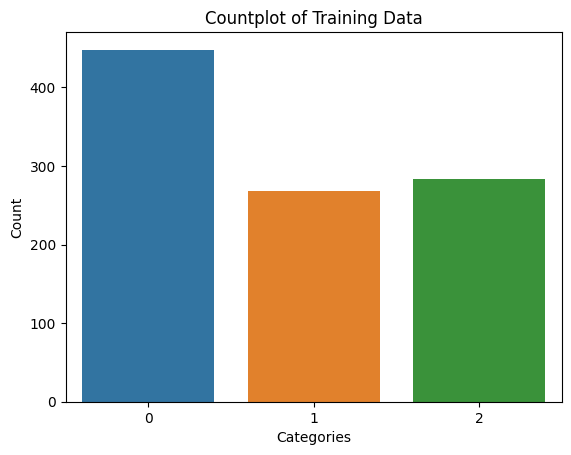

In [ ]:
sns.countplot(x=l)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Countplot of Training Data')
plt.show()
#where 0 -'Normal', 1 - 'Covid', 2 - 'Viral Pneumonia'

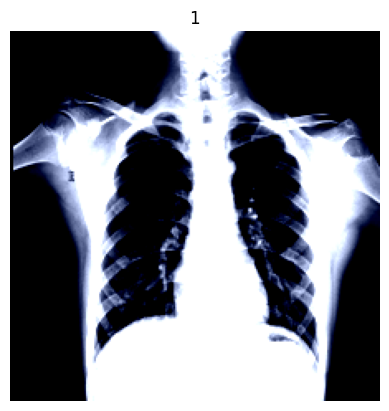

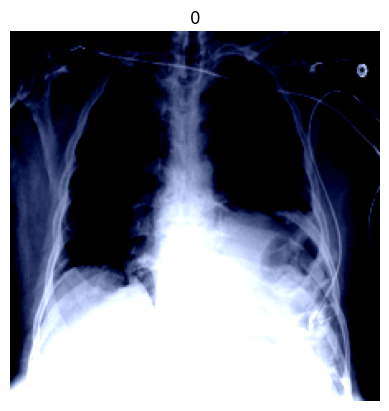

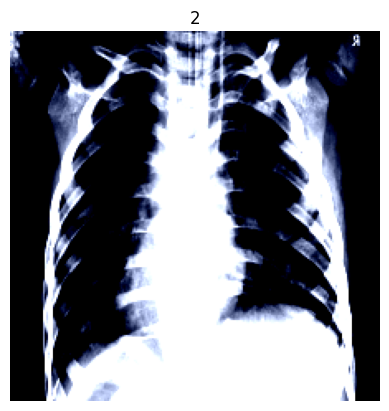

In [ ]:
for i in range(4,7):
    images, labels = train_ds[i]
    img_grid = make_grid(images, nrow=5)
    img_grid = np.transpose(img_grid, (1, 2, 0))

    plt.imshow(img_grid)
    plt.title(labels)
    plt.axis('off')
    plt.show()

In [ ]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
test_tfms = tt.Compose([tt.Resize((256,256), interpolation=2),
                         tt.ToTensor(),
                         tt.Normalize(*stats)])
normal_ds = ImageFolder(data_dir+'/train', test_tfms)
normal_dl = DataLoader(normal_ds, 1, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Needed Functions

In [ ]:
def train(model,train_dl,valid_dl,criterion,optimizer,num_epochs=100):
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0
      for inputs, labels in tqdm(train_dl):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

          _, predicted_train = torch.max(outputs.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted_train == labels).sum().item()

      avg_train_loss = running_loss / len(train_dl)
      avg_train_accuracy = correct_train / total_train

      model.eval()
      correct_val = 0
      total_val = 0
      val_loss = 0.0
      with torch.no_grad():
          for inputs, labels in tqdm(valid_dl):
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, labels)

              val_loss += loss.item()

              _, predicted_val = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted_val == labels).sum().item()

      avg_val_loss = val_loss / len(valid_dl)
      avg_val_accuracy = correct_val / total_val

      train_losses.append(avg_train_loss)
      val_losses.append(avg_val_loss)
      train_accuracies.append(avg_train_accuracy)
      val_accuracies.append(avg_val_accuracy)

  return train_losses,train_accuracies,val_losses,val_accuracies

In [ ]:
def plotting(train_losses,train_accuracies,val_losses,val_accuracies):
  epochs_range = range(1, len(train_losses) + 1)

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_losses, label='Training Loss')
  plt.plot(epochs_range, val_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
  plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
def train_fit(model,train_dl,valid_dl,criterion,optimizer,num_epochs=100):
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  best_val_accuracy = 0.0
  patience = 5
  counter = 0
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0
      for inputs, labels in tqdm(train_dl):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

          _, predicted_train = torch.max(outputs.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted_train == labels).sum().item()

      avg_train_loss = running_loss / len(train_dl)
      avg_train_accuracy = correct_train / total_train

      model.eval()
      correct_val = 0
      total_val = 0
      val_loss = 0.0
      with torch.no_grad():
          for inputs, labels in tqdm(valid_dl):
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, labels)

              val_loss += loss.item()

              _, predicted_val = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted_val == labels).sum().item()

      avg_val_loss = val_loss / len(valid_dl)
      avg_val_accuracy = correct_val / total_val

      train_losses.append(avg_train_loss)
      val_losses.append(avg_val_loss)
      train_accuracies.append(avg_train_accuracy)
      val_accuracies.append(avg_val_accuracy)

      if avg_val_accuracy > best_val_accuracy:
          best_val_accuracy = avg_val_accuracy
          counter = 0
      else:
          counter += 1

      if counter >= patience:
          print("Early stopping: No improvement in validation accuracy.")
          return train_losses,train_accuracies,val_losses,val_accuracies

  return train_losses,train_accuracies,val_losses,val_accuracies

In [ ]:
def predict(model, dataloader):
    model.eval()
    pred = []
    true = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            pred.extend(predicted.cpu().numpy())
            true.extend(labels.cpu().numpy())

    return pred, true

#mobilent_v2

In [ ]:
base_model = models.mobilenet_v2(weights=True)
for param in base_model.parameters():
    param.requires_grad = False

num_features = base_model.classifier[1].in_features
base_model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 3),
    nn.Softmax(dim=1)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = base_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 24.2MB/s]


In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses,train_accuracies,val_losses,val_accuracies = train(model,train_dl,valid_dl,criterion,optimizer,num_epochs=10)

100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


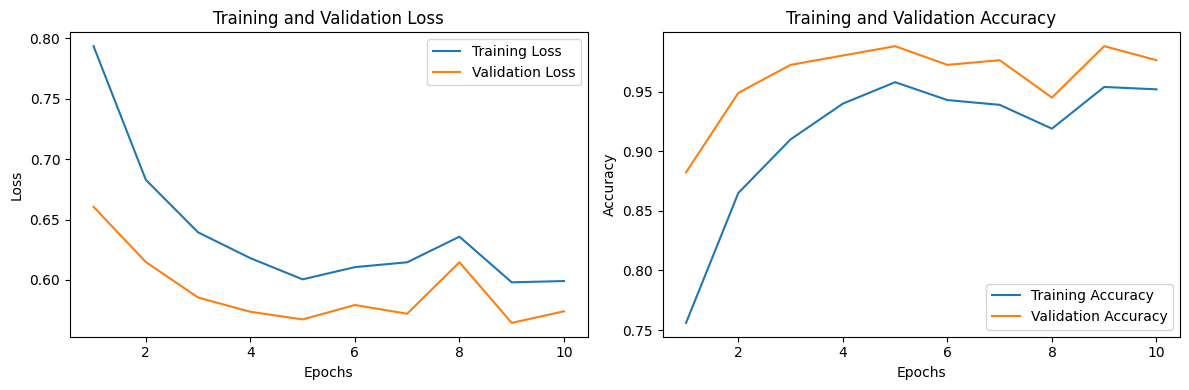

In [ ]:
plotting(train_losses,train_accuracies,val_losses,val_accuracies)

In [ ]:
test_predictions, test_ground_truth = predict(model, test_dl)
accuracy_score(test_predictions, test_ground_truth )

0.9545454545454546

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.90      0.95        20
           2       0.90      0.95      0.93        20

    accuracy                           0.95        66
   macro avg       0.96      0.95      0.95        66
weighted avg       0.96      0.95      0.95        66



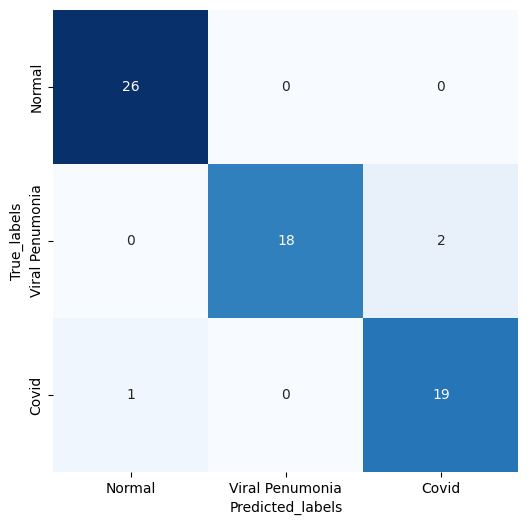

In [ ]:
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(test_ground_truth,test_predictions), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(test_ground_truth,test_predictions))

# Xception

In [ ]:
import timm

base_model = timm.create_model('xception', pretrained=True)
for param in base_model.parameters():
    param.requires_grad = False

num_classes = 3
base_model.fc = nn.Sequential(
    nn.Linear(base_model.num_features, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(64, num_classes),
    nn.Softmax(dim=1)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = base_model.to(device)


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
            Conv2d-4         [-1, 64, 109, 109]          18,432
       BatchNorm2d-5         [-1, 64, 109, 109]             128
              ReLU-6         [-1, 64, 109, 109]               0
            Conv2d-7         [-1, 64, 109, 109]             576
            Conv2d-8        [-1, 128, 109, 109]           8,192
   SeparableConv2d-9        [-1, 128, 109, 109]               0
      BatchNorm2d-10        [-1, 128, 109, 109]             256
             ReLU-11        [-1, 128, 109, 109]               0
           Conv2d-12        [-1, 128, 109, 109]           1,152
           Conv2d-13        [-1, 128, 109, 109]          16,384
  SeparableConv2d-14        [-1, 128, 1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses,train_accuracies,val_losses,val_accuracies = train(model,train_dl,valid_dl,criterion,optimizer,num_epochs=10)

  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 8/8 [00:11<00:00,  1.44s/it]


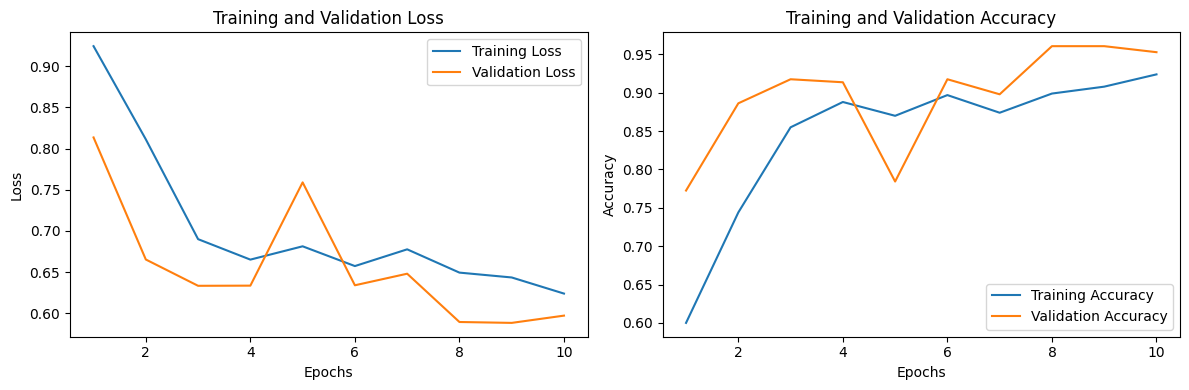

In [ ]:
plotting(train_losses,train_accuracies,val_losses,val_accuracies)

In [ ]:
pred,true = predict(model,test_dl)
accuracy_score(pred,true)

0.8787878787878788

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.80      0.80      0.80        20
           2       0.80      0.80      0.80        20

    accuracy                           0.88        66
   macro avg       0.87      0.87      0.87        66
weighted avg       0.88      0.88      0.88        66



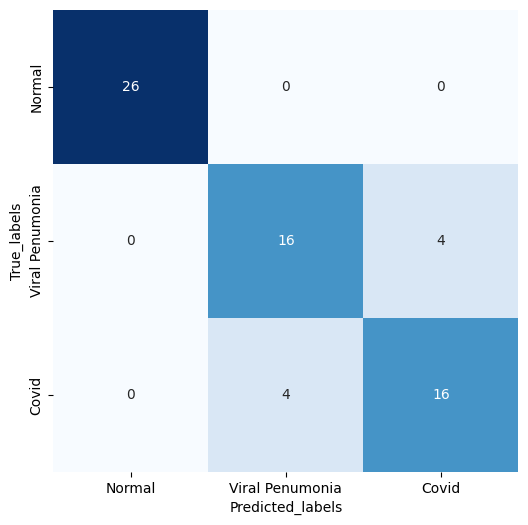

In [ ]:
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(true,pred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(true,pred))

# Custom

In [ ]:
train_set, val_set = torch.utils.data.random_split(train_ds, [800, 204])

In [ ]:
batch_size = 2
train_dl = DataLoader(train_set, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_set, batch_size*2, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)
len(test_dl)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


17

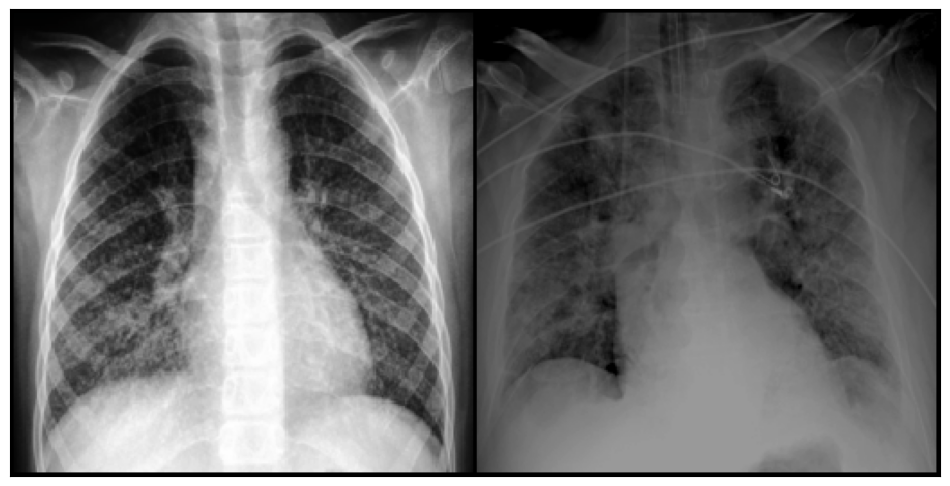

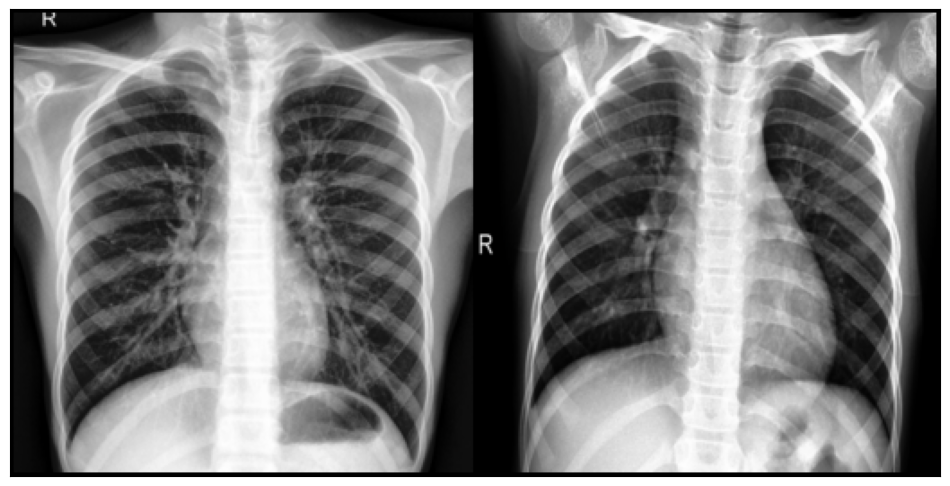

In [ ]:
import matplotlib.image as mpimg

def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1,3,1,1)
  stds = torch.tensor(stds).reshape(1,3,1,1)
  return images*stds + means

def show_grid(dl):
  i = 0
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(images[:20], *stats)
    ax.imshow(make_grid(denorm_images[:20], nrow=5).permute(1, 2, 0).clamp(0,1))
    i += 1
    if i == 2: break
show_grid(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 256, pool=True)
        self.res1 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

        self.conv3 = conv_block(256, 512, pool=True)
        self.conv4 = conv_block(512, 1024, pool=True)
        self.res2 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))

        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=32),
                                        nn.MaxPool2d(2),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(1024*16*16, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out
model = to_device(ResNet9(3, 3), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
torch.cuda.empty_cache()
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.096911907196045, 'val_acc': 0.2647058963775635}]

In [ ]:
epochs = 8
max_lr = 0.02
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                         grad_clip = grad_clip,
                         weight_decay = weight_decay,
                         opt_func = opt_func)

Epoch [0], last_lr: 0.00790, train_loss: 93.8866, val_loss: 21.4293, val_acc: 0.8922
Epoch [1], last_lr: 0.01871, train_loss: 71.4238, val_loss: 10.5915, val_acc: 0.8725
Epoch [2], last_lr: 0.01944, train_loss: 7.9478, val_loss: 2.8953, val_acc: 0.8873
Epoch [3], last_lr: 0.01623, train_loss: 1.9984, val_loss: 1.1382, val_acc: 0.9020
Epoch [4], last_lr: 0.01112, train_loss: 1.8159, val_loss: 0.9911, val_acc: 0.9706
Epoch [5], last_lr: 0.00566, train_loss: 9.0037, val_loss: 4.4905, val_acc: 0.9167
Epoch [6], last_lr: 0.00153, train_loss: 1.7678, val_loss: 1.5228, val_acc: 0.9412
Epoch [7], last_lr: 0.00000, train_loss: 1.1986, val_loss: 0.5513, val_acc: 0.9706


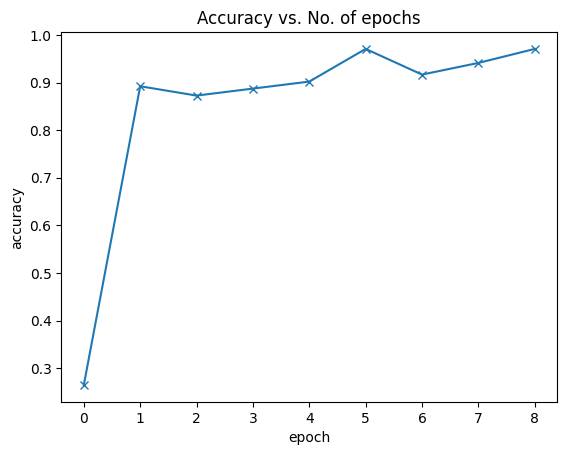

In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')
plot_accuracies(history)

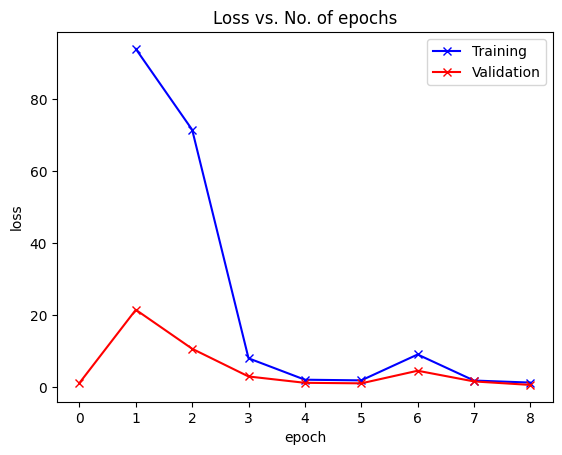

In [ ]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx', label='Training')
  plt.plot(val_losses, '-rx', label='Validation')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.title('Loss vs. No. of epochs');
plot_losses(history)

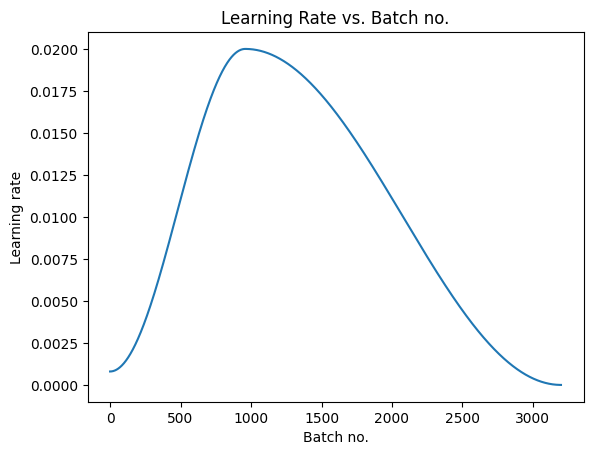

In [ ]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [ ]:
def predict_image(img, model):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return preds[0].item()

Label: 0 , Predicted: 0


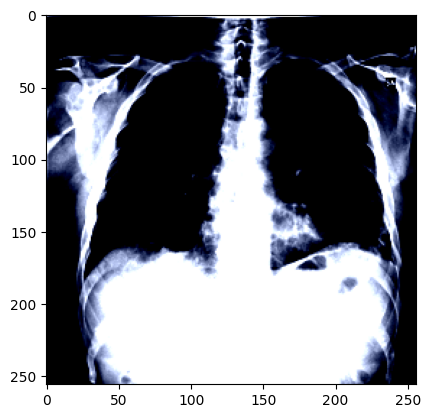

In [ ]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


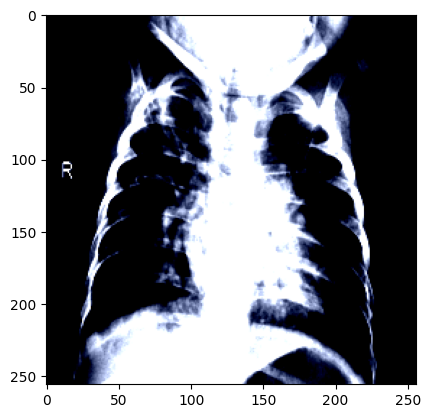

In [ ]:
img, label = test_ds[60]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 1 , Predicted: 1


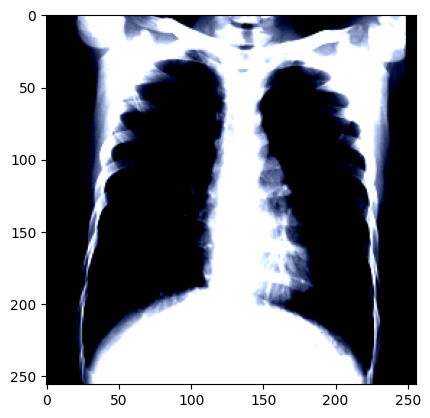

In [ ]:
img, label = test_ds[30]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
torch.save(model.state_dict(), 'covid-19-pneumonia-resnet9.pth')

In [ ]:
ytest = []
ypred = []
for i in range(len(test_ds)):
  img, label = test_ds[i]
  ytest.append(label)
  ypred.append(predict_image(img, model))
#print('Label:', label, ', Predicted:', predict_image(img, model))


              precision    recall  f1-score   support

           0       0.89      0.92      0.91        26
           1       0.86      0.90      0.88        20
           2       0.94      0.85      0.89        20

    accuracy                           0.89        66
   macro avg       0.90      0.89      0.89        66
weighted avg       0.90      0.89      0.89        66



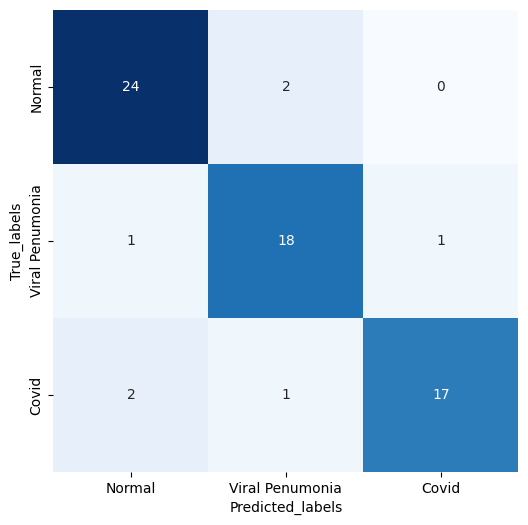

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))

# Resnet - 50

In [ ]:
model_name = 'resnet50'

resnet = models.__dict__[model_name](pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False

num_classes = 3
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(64, num_classes),
    nn.Softmax(dim=1)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)


In [ ]:
summary(resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

In [ ]:
train_losses,train_accuracies,val_losses,val_accuracies = train(resnet,train_dl,valid_dl,criterion,optimizer,num_epochs=10)

100%|██████████| 8/8 [01:08<00:00,  8.55s/it]


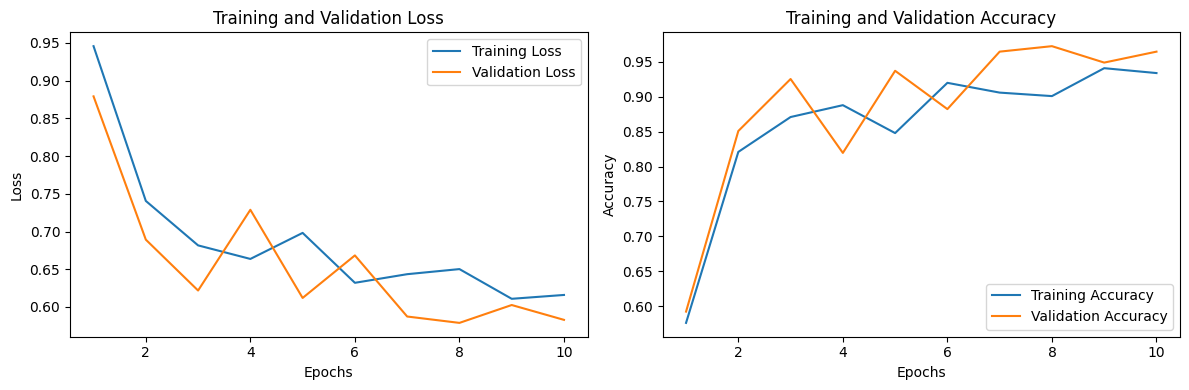

In [ ]:
plotting(train_losses,train_accuracies,val_losses,val_accuracies)

In [ ]:
pred,true = predict(resnet,test_dl)
accuracy_score(pred,true)

0.9090909090909091

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      0.80      0.89        20
           2       0.83      1.00      0.91        20

    accuracy                           0.94        66
   macro avg       0.94      0.93      0.93        66
weighted avg       0.95      0.94      0.94        66



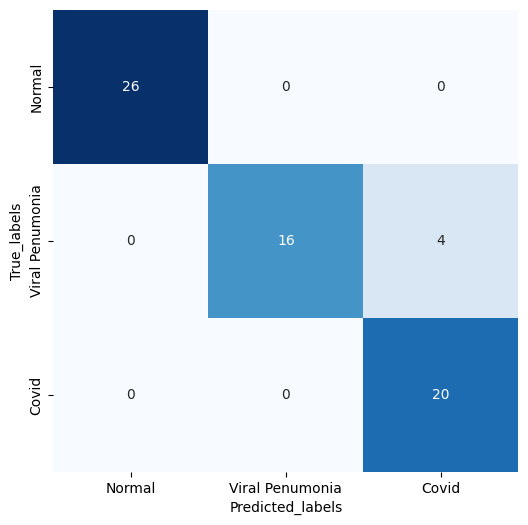

In [ ]:
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(true,pred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(true,pred))

# VGG - 16

In [ ]:
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False

num_classes = 3
in_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(64, num_classes),
    nn.Softmax(dim=1)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 123MB/s] 


In [ ]:
summary(vgg16, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)

In [ ]:
train_losses,train_accuracies,val_losses,val_accuracies = train(vgg16,train_dl,valid_dl,criterion,optimizer,num_epochs=10)

  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


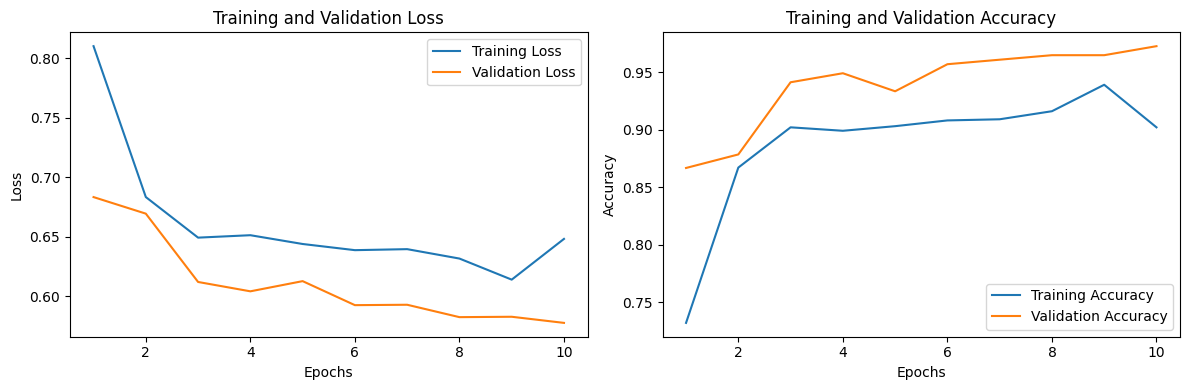

In [ ]:
plotting(train_losses,train_accuracies,val_losses,val_accuracies)

In [ ]:
pred,true = predict(vgg16,test_dl)
accuracy_score(pred,true)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0.9696969696969697

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      0.90      0.95        20
           2       0.91      1.00      0.95        20

    accuracy                           0.97        66
   macro avg       0.97      0.97      0.97        66
weighted avg       0.97      0.97      0.97        66



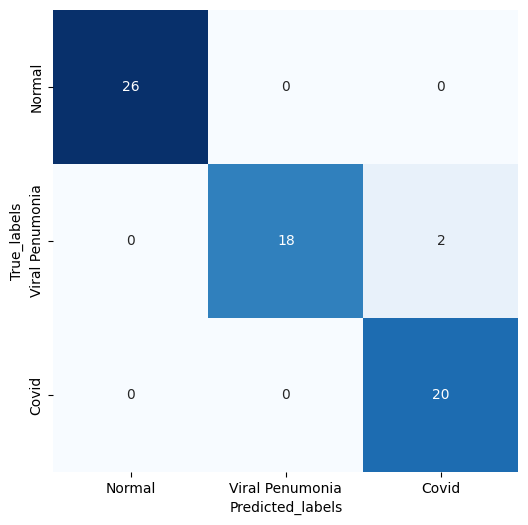

In [ ]:
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(true,pred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(true,pred))

# GANS

In [ ]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, condition_dim):
        super(ConditionalGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 4 * 4 * 1024),
            nn.BatchNorm1d(4 * 4 * 1024),
            nn.LeakyReLU(),
            nn.Unflatten(1, (1024, 4, 4)),
            nn.ConvTranspose2d(1024, 512, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        return self.model(x)

class ConditionalDiscriminator(nn.Module):
    def __init__(self, condition_dim):
        super(ConditionalDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1 + condition_dim, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Conv2d(512, 1024, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(4 * 4 * 1024, 64),
            nn.Linear(64, 32),
            nn.Linear(32, 16),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        y = y.view(-1, condition_dim, 1, 1)  # adjust dimensions based on your label format
        x = torch.cat([x, y.expand(-1, -1, x.size(2), x.size(3))], dim=1)

        return self.model(x)

latent_dim = 100
condition_dim = 3
generator = ConditionalGenerator(latent_dim, condition_dim)
discriminator = ConditionalDiscriminator(condition_dim)


generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


criterion = nn.BCELoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

In [ ]:
#generator = np.load('/content/drive/MyDrive/conditional_generator_intermediate_400.pth')
generator.load_state_dict(torch.load('/content/drive/MyDrive/conditional_generator_intermediate_400.pth'))
generator.eval()

# Visualizations - Synthetic

In [ ]:
import seaborn as sns
l = []
for i in train_ds:
    l.append(i[1])

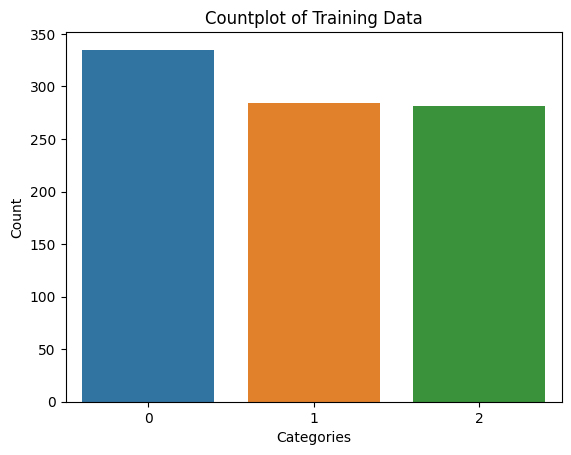

In [ ]:
sns.countplot(x=l)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Countplot of Training Data')
plt.show()
#where 0 -'Normal', 1 - 'Covid', 2 - 'Viral Pneumonia'

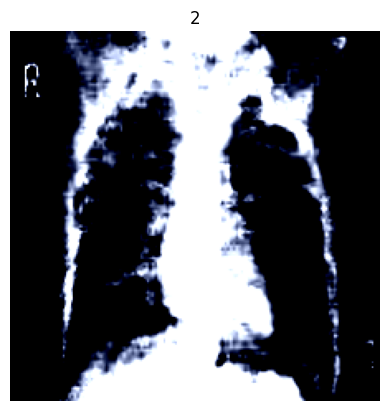

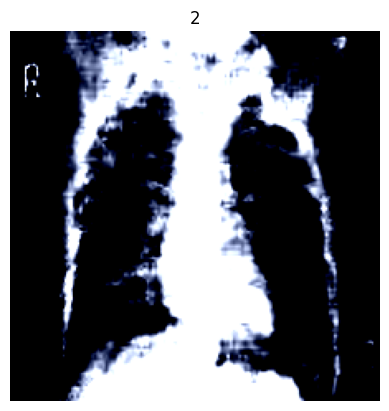

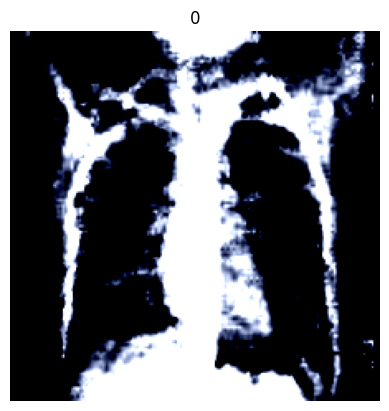

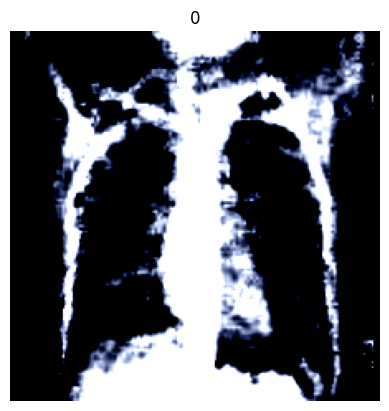

In [ ]:
for i in range(10,14):
    images, labels = train_ds[i]
    img_grid = make_grid(images, nrow=5)
    img_grid = np.transpose(img_grid, (1, 2, 0))

    plt.imshow(img_grid)
    plt.title(labels)
    plt.axis('off')
    plt.show()

In [ ]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)

# Needed Functions

In [ ]:
def train(model,train_dl,valid_dl,criterion,optimizer,num_epochs=100):
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0
      for inputs, labels in tqdm(train_dl):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

          _, predicted_train = torch.max(outputs.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted_train == labels).sum().item()

      avg_train_loss = running_loss / len(train_dl)
      avg_train_accuracy = correct_train / total_train

      model.eval()
      correct_val = 0
      total_val = 0
      val_loss = 0.0
      with torch.no_grad():
          for inputs, labels in tqdm(valid_dl):
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, labels)

              val_loss += loss.item()

              _, predicted_val = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted_val == labels).sum().item()

      avg_val_loss = val_loss / len(valid_dl)
      avg_val_accuracy = correct_val / total_val

      train_losses.append(avg_train_loss)
      val_losses.append(avg_val_loss)
      train_accuracies.append(avg_train_accuracy)
      val_accuracies.append(avg_val_accuracy)

  return train_losses,train_accuracies,val_losses,val_accuracies

In [ ]:
def plotting(train_losses,train_accuracies,val_losses,val_accuracies):
  epochs_range = range(1, len(train_losses) + 1)

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_losses, label='Training Loss')
  plt.plot(epochs_range, val_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
  plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
def train_fit(model,train_dl,valid_dl,criterion,optimizer,num_epochs=100):
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  best_val_accuracy = 0.0
  patience = 5
  counter = 0
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0
      for inputs, labels in tqdm(train_dl):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

          _, predicted_train = torch.max(outputs.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted_train == labels).sum().item()

      avg_train_loss = running_loss / len(train_dl)
      avg_train_accuracy = correct_train / total_train

      model.eval()
      correct_val = 0
      total_val = 0
      val_loss = 0.0
      with torch.no_grad():
          for inputs, labels in tqdm(valid_dl):
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, labels)

              val_loss += loss.item()

              _, predicted_val = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted_val == labels).sum().item()

      avg_val_loss = val_loss / len(valid_dl)
      avg_val_accuracy = correct_val / total_val

      train_losses.append(avg_train_loss)
      val_losses.append(avg_val_loss)
      train_accuracies.append(avg_train_accuracy)
      val_accuracies.append(avg_val_accuracy)

      if avg_val_accuracy > best_val_accuracy:
          best_val_accuracy = avg_val_accuracy
          counter = 0
      else:
          counter += 1

      if counter >= patience:
          print("Early stopping: No improvement in validation accuracy.")
          return train_losses,train_accuracies,val_losses,val_accuracies

  return train_losses,train_accuracies,val_losses,val_accuracies

In [ ]:
def predict(model, dataloader):
    model.eval()
    pred = []
    true = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            pred.extend(predicted.cpu().numpy())
            true.extend(labels.cpu().numpy())

    return pred, true

#mobilent_v2

In [ ]:
base_model = models.mobilenet_v2(weights=True)
for param in base_model.parameters():
    param.requires_grad = False

num_features = base_model.classifier[1].in_features
base_model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 3),
    nn.Softmax(dim=1)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = base_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 158MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses,train_accuracies,val_losses,val_accuracies = train(model,train_dl,valid_dl,criterion,optimizer,num_epochs=10)

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]


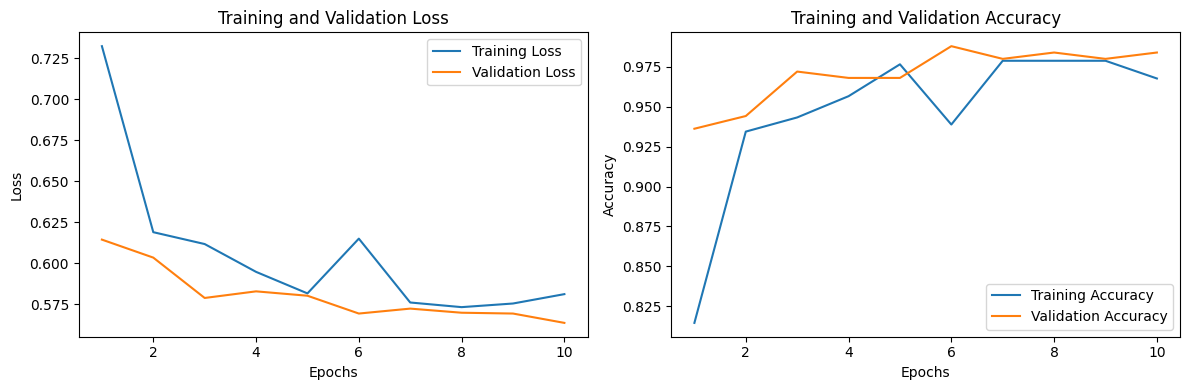

In [ ]:
plotting(train_losses,train_accuracies,val_losses,val_accuracies)

In [ ]:
pred,true = predict(model,test_dl)
accuracy_score(pred,true)

0.9242424242424242

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.86      0.90      0.88        20
           2       0.90      0.90      0.90        20

    accuracy                           0.92        66
   macro avg       0.92      0.92      0.92        66
weighted avg       0.93      0.92      0.93        66



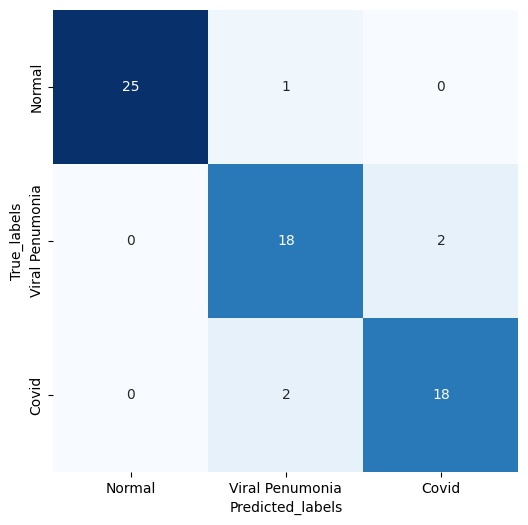

In [ ]:
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(true,pred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(true,pred))

# Xception

In [ ]:
import timm

base_model = timm.create_model('xception', pretrained=True)
for param in base_model.parameters():
    param.requires_grad = False

num_classes = 3
base_model.fc = nn.Sequential(
    nn.Linear(base_model.num_features, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(64, num_classes),
    nn.Softmax(dim=1)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = base_model.to(device)


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses,train_accuracies,val_losses,val_accuracies = train(model,train_dl,valid_dl,criterion,optimizer,num_epochs=10)

  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


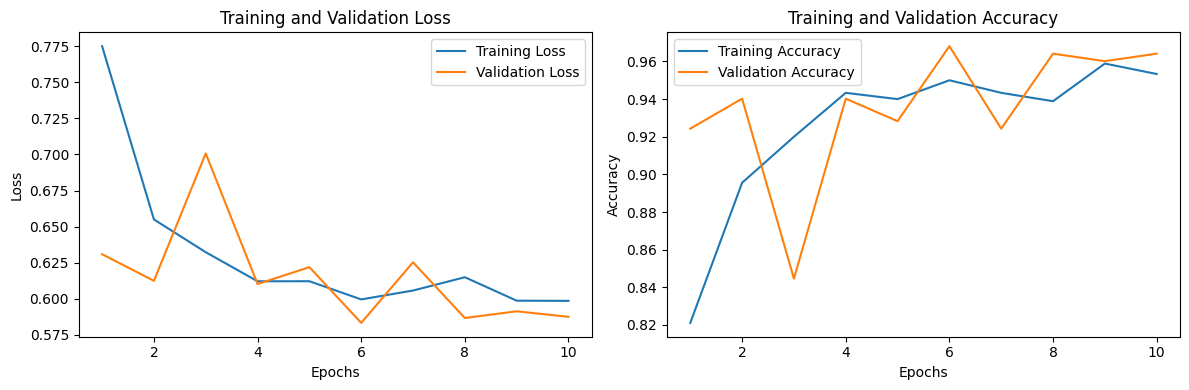

In [ ]:
plotting(train_losses,train_accuracies,val_losses,val_accuracies)

In [ ]:
pred,true = predict(model,test_dl)
accuracy_score(pred,true)

0.6666666666666666

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        26
           1       0.67      0.30      0.41        20
           2       0.48      0.80      0.60        20

    accuracy                           0.67        66
   macro avg       0.69      0.65      0.63        66
weighted avg       0.71      0.67      0.66        66



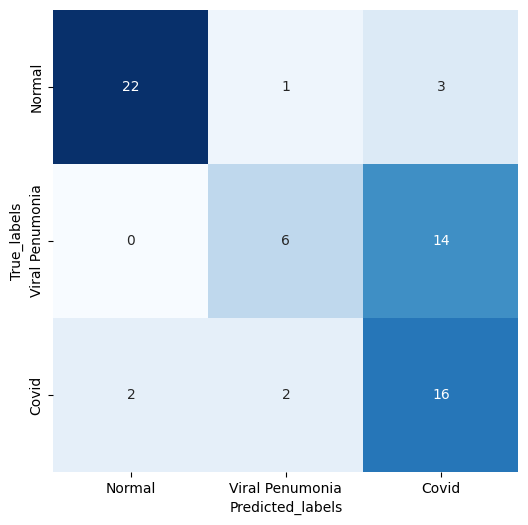

In [ ]:
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(true,pred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(true,pred))

# Custom

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 256, pool=True)
        self.res1 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

        self.conv3 = conv_block(256, 512, pool=True)
        self.conv4 = conv_block(512, 1024, pool=True)
        self.res2 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))

        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=32),
                                        nn.MaxPool2d(2),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(1024*16*16, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out
model = to_device(ResNet9(3, 3), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
torch.cuda.empty_cache()
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[{'val_loss': 1.0972086191177368, 'val_acc': 0.3829571604728699}]

In [ ]:
epochs = 8
max_lr = 0.02
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                         grad_clip = grad_clip,
                         weight_decay = weight_decay,
                         opt_func = opt_func)

Epoch [0], last_lr: 0.00779, train_loss: 33.9638, val_loss: 8581.7324, val_acc: 0.3830
Epoch [1], last_lr: 0.01870, train_loss: 43.7060, val_loss: 1889.9011, val_acc: 0.3471
Epoch [2], last_lr: 0.01944, train_loss: 30.2394, val_loss: 59.5393, val_acc: 0.7044
Epoch [3], last_lr: 0.01623, train_loss: 9.7436, val_loss: 13.0298, val_acc: 0.9492
Epoch [4], last_lr: 0.01112, train_loss: 5.0604, val_loss: 6.9654, val_acc: 0.9446
Epoch [5], last_lr: 0.00566, train_loss: 3.0165, val_loss: 7.5836, val_acc: 0.9524
Epoch [6], last_lr: 0.00153, train_loss: 1.1231, val_loss: 4.1617, val_acc: 0.9719
Epoch [7], last_lr: 0.00000, train_loss: 0.3814, val_loss: 3.9719, val_acc: 0.9719


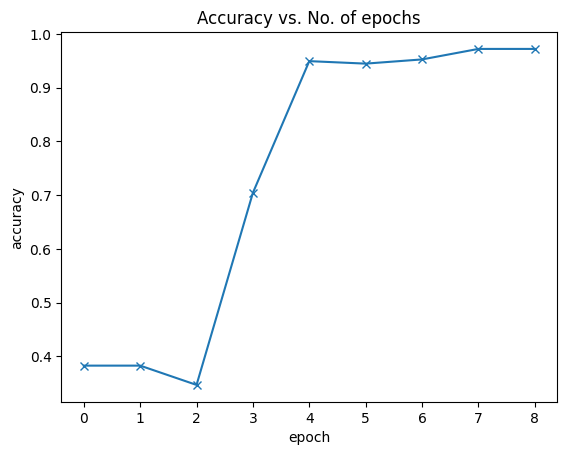

In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')
plot_accuracies(history)

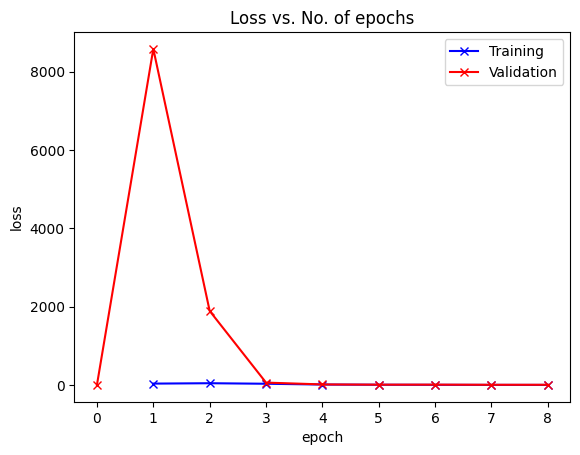

In [ ]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx', label='Training')
  plt.plot(val_losses, '-rx', label='Validation')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.title('Loss vs. No. of epochs');
plot_losses(history)

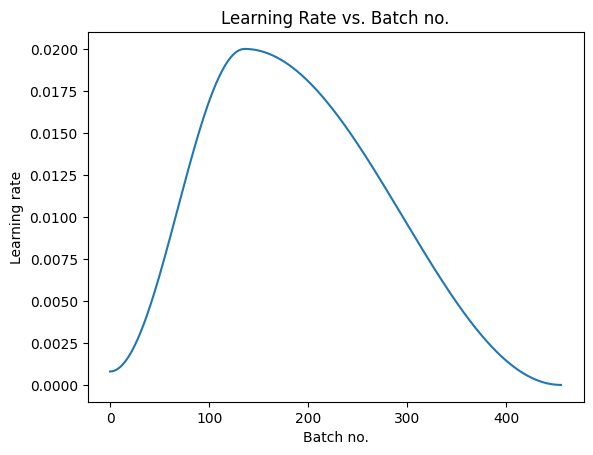

In [ ]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [ ]:
def predict_image(img, model):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return preds[0].item()

In [ ]:
ytest = []
ypred = []
for i in range(len(test_ds)):
  img, label = test_ds[i]
  ytest.append(label)
  ypred.append(predict_image(img, model))
#print('Label:', label, ', Predicted:', predict_image(img, model))


In [ ]:
accuracy_score(ypred,ytest)

0.8484848484848485

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.75      0.75      0.75        20
           2       0.76      0.80      0.78        20

    accuracy                           0.85        66
   macro avg       0.84      0.84      0.84        66
weighted avg       0.85      0.85      0.85        66



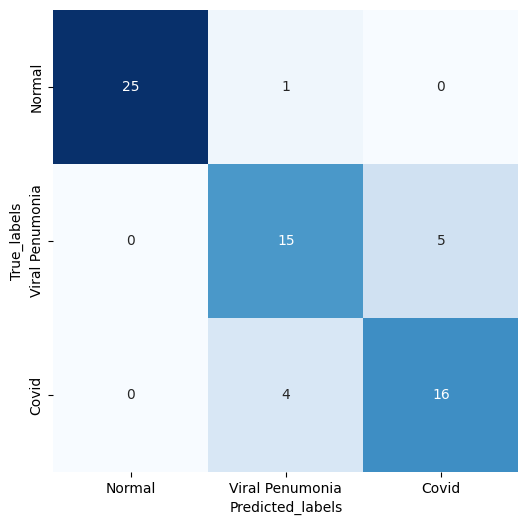

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))

# Resnet - 50

In [ ]:
model_name = 'resnet50'

resnet = models.__dict__[model_name](pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False

num_classes = 3
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(64, num_classes),
    nn.Softmax(dim=1)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 73.6MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

In [ ]:
train_losses,train_accuracies,val_losses,val_accuracies = train(resnet,train_dl,valid_dl,criterion,optimizer,num_epochs=10)

  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


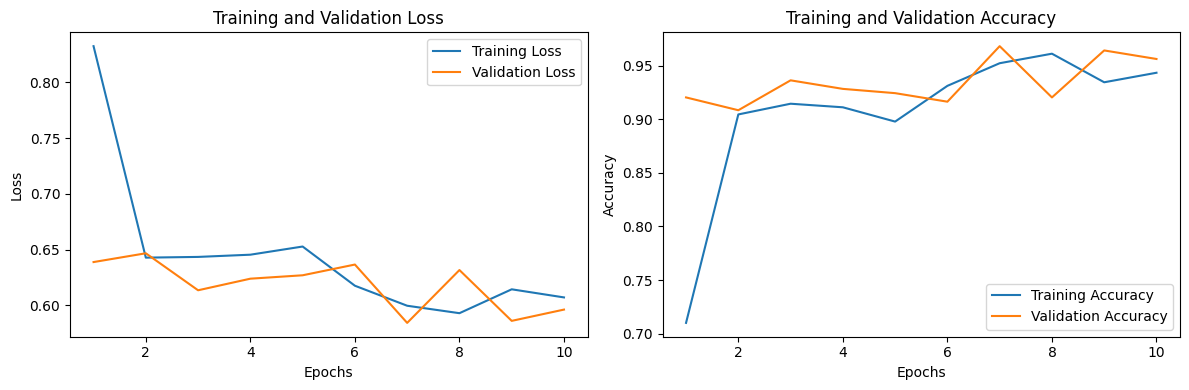

In [ ]:
plotting(train_losses,train_accuracies,val_losses,val_accuracies)

In [ ]:
pred,true = predict(resnet,test_dl)
accuracy_score(pred,true)

0.7878787878787878

              precision    recall  f1-score   support

           0       0.74      0.96      0.83        26
           1       0.78      0.90      0.84        20
           2       1.00      0.45      0.62        20

    accuracy                           0.79        66
   macro avg       0.84      0.77      0.76        66
weighted avg       0.83      0.79      0.77        66



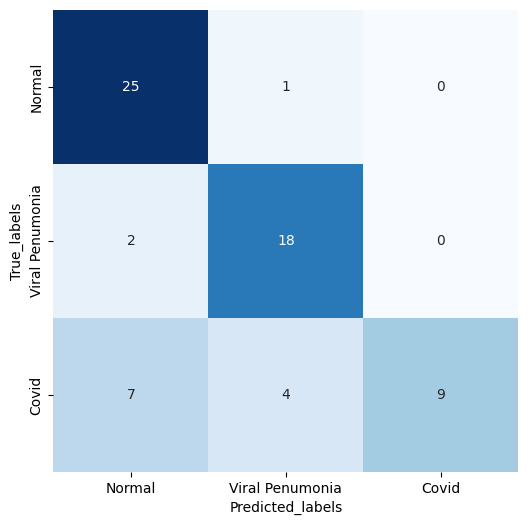

In [ ]:
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(true,pred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(true,pred))

# VGG - 16

In [ ]:
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False

num_classes = 3
in_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(64, num_classes),
    nn.Softmax(dim=1)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 70.3MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)

In [ ]:
train_losses,train_accuracies,val_losses,val_accuracies = train(vgg16,train_dl,valid_dl,criterion,optimizer,num_epochs=10)

  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 8/8 [00:02<00:00,  2.70it/s]


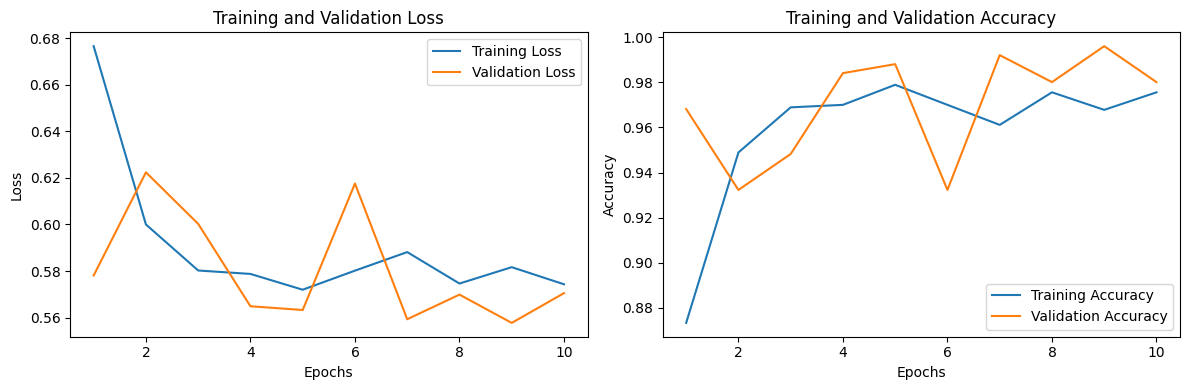

In [ ]:
plotting(train_losses,train_accuracies,val_losses,val_accuracies)

In [ ]:
pred,true = predict(vgg16,test_dl)
accuracy_score(pred,true)

0.8333333333333334

              precision    recall  f1-score   support

           0       1.00      0.81      0.89        26
           1       0.71      0.85      0.77        20
           2       0.81      0.85      0.83        20

    accuracy                           0.83        66
   macro avg       0.84      0.84      0.83        66
weighted avg       0.85      0.83      0.84        66



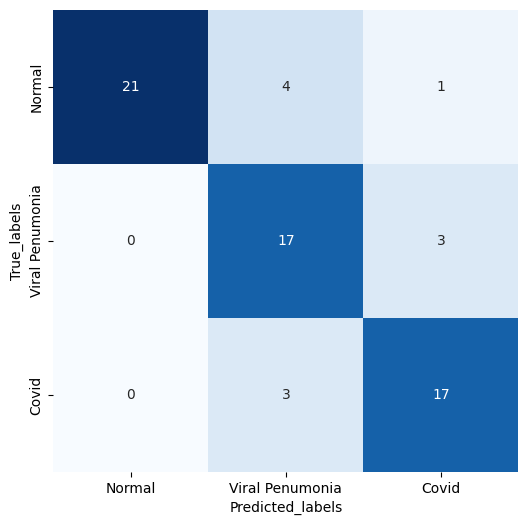

In [ ]:
plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(true,pred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(true,pred))